<a href="https://colab.research.google.com/github/unmtransinfo/CFChemDb/blob/main/notebooks/CFChemDb_RDKit_Colaboratory_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://www.nih-cfde.org/wp-content/uploads/2020/11/CFDE_logo-color-web.png" width="200">

# CFChemDb and RDKit Colaboratory demo and hands-on tutorial

* https://www.nih-cfde.org/
* https://github.com/unmtransinfo/CFChemDb
* https://www.rdkit.org/docs/Cartridge.html

In this simple CFDE-IDG demo we pull CFChemDb data from AWS EC2 cloud instance, for display, analysis and integration with related entities and datasets. The RDKit PostgreSQL Cartridge provides chemically intelligent search. Google Colaboratory provides accessibility and ease of use.

In [1]:
!pip install rdkit-pypi
!pip install psycopg2-binary
import sys,os,json,base64,io,requests,urllib.request
import pandas as pd
import psycopg2,psycopg2.extras
from IPython.core.display import display, HTML
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 4.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 8.9 MB/s 


### Database credentials

In [2]:
dsn = (f"host='unmtid-dbs.net' port='5442' dbname='cfchemdb' user='commoner' password='easement'")
dbcon = psycopg2.connect(dsn)
dbcon.cursor_factory = psycopg2.extras.DictCursor

Metadata table contains information about the db release.

In [3]:
pd.read_sql(f"SELECT * FROM meta", dbcon).transpose()

,0
field,timestamp
value,2022-02-09
description,Date of build.


### Tables and columns summary
row-counts

In [4]:
tables = pd.read_sql(f"SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'", dbcon)
rowcounts=None;
for tname in tables.table_name:
  df_this = pd.read_sql(f"SELECT COUNT(*) AS rowcount FROM {tname}", dbcon)
  df_this["table"] = tname
  rowcounts = df_this if rowcounts is None else pd.concat([rowcounts, df_this])
rowcounts = rowcounts[["table", "rowcount"]]
rowcounts

,table,rowcount
0,drugcentral,4713
0,glygen,33531
0,idg,251677
0,lincs,32469
0,meta,1
0,mols,311041
0,properties,311041
0,refmet,154676
0,reprotox,965


Columns

In [5]:
columns=None;
for tname in tables.table_name:
  sql2 = (f"SELECT column_name,data_type FROM information_schema.columns WHERE table_schema = 'public' AND table_name = '{tname}'")
  df_this = pd.read_sql(sql2, dbcon)
  df_this["table"] = tname
  columns = df_this if columns is None else pd.concat([columns, df_this])
columns[["table", "column_name"]].groupby(["table"]).agg(lambda x: ', '.join(x))

,column_name
table,
drugcentral,"id, name, cas_reg_no, smiles, inchikey, inchi,..."
glygen,"glycan_type, mass_pme, number_monosaccharides,..."
idg,"pubchem_cid, smiles, target_count, activity_co..."
lincs,"id, pert_name, target, moa, smiles, inchi_key,..."
meta,"field, value, description"
mols,"id, name, cansmi, molecule, fp, ecfp"
properties,"mol_id, mol_wt, exact_mol_wt, heavy_atom_mol_w..."
refmet,"refmet_name, super_class, main_class, sub_clas..."
reprotox,"ls_id, cas_rn, pubchem_cid, smiles, term, cans..."


### DrugCentral drug summary
Note that ID corresponds with DrugCentral drug page, e.g. https://drugcentral.org/drugcard/2358

In [6]:
drug = pd.read_sql("SELECT * FROM drugcentral dc WHERE name = 'ranitidine'", dbcon)
drug.transpose()

,0
id,2358
name,ranitidine
cas_reg_no,66357-35-5
smiles,CNC(NCCSCC1=CC=C(CN(C)C)O1)=C[N+]([O-])=O
inchikey,VMXUWOKSQNHOCA-UHFFFAOYSA-N
inchi,InChI=1S/C13H22N4O3S/c1-14-13(9-17(18)19)15-6-...
formula,C13H22N4O3S
molweight,314.4
cansmi,CNC(=C[N+](=O)[O-])NCCSCc1ccc(CN(C)C)o1
mol_id,1184


### Depict chemical structure
Additional RDKit example code can be found via https://www.rdkit.org/ and several Jupyter notebooks in the UGM materials (e.g. https://github.com/rdkit/UGM_2021) and blog, https://rdkit.blogspot.com/. 

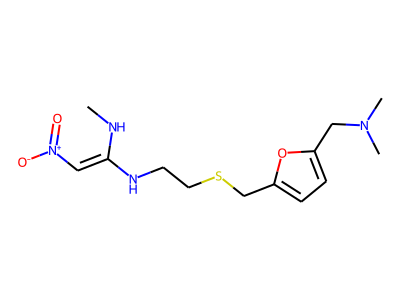

In [7]:
Draw.MolToImage(Chem.MolFromSmiles(drug['smiles'][0]), size=(400, 300)) 

### Properties from properties table

In [8]:
drug_props = pd.read_sql(f"SELECT * FROM properties p WHERE mol_id = {drug['mol_id'][0]}", dbcon)
drug_props.transpose()

,0
mol_id,1184.000
mol_wt,314.411
exact_mol_wt,314.141
heavy_atom_mol_wt,292.235
max_abs_partial_charge,0.464
max_partial_charge,0.274
min_abs_partial_charge,0.274
min_partial_charge,-0.464
num_radical_electrons,0.000
num_valence_electrons,118.000


<img align="right" src="https://druggablegenome.net/IDG_Images_Index/IDGLOGO.png" height="60">

### IDG sample
Sample compounds from the IDG table.

In [9]:
idg_sample = pd.read_sql("SELECT * FROM idg WHERE cansmi IS NOT NULL ORDER BY RANDOM() LIMIT 6", dbcon)
idg_sample

,pubchem_cid,smiles,target_count,activity_count,cansmi,mol_id,name
0,60785,Fc1ccc(cc1)N1CCN(CC1)CCCN1c2cccc3c2c(S1(=O)=O)...,1,1,O=S1(=O)c2cccc3cccc(c23)N1CCCN1CCN(c2ccc(F)cc2...,2135,Fananserin
1,121428526,CCn1ncc2cc3NC(=O)N[C@H](COC[C@@H](O)Cc(n3)c12)...,1,1,CCn1ncc2cc3nc(c21)C[C@H](O)COC[C@H](c1ccc(OC)c...,231995,SCHEMBL17859855
2,86297090,Cc1ccc(cc1c2ccnc(c2)N3CCOCC3)N=C(O)c4cccc(c4)C...,2,2,Cc1ccc(N=C(O)c2cccc(C(F)F)c2)cc1-c1ccnc(N2CCOC...,196560,SCHEMBL16035246
3,25093325,Cc1c[nH]nc1c2ccc(cc2)c3cn(C)nc3c4ccncc4,1,2,Cc1c[nH]nc1-c1ccc(-c2cn(C)nc2-c2ccncc2)cc1,67971,BDBM25652
4,52942879,O=C(Nc1ccc(cc1)c2nc(nc(n2)N3C4CCC3COC4)N5CCOCC...,1,1,O=C(Nc1ccc(-c2nc(N3CCOCC3)nc(N3C4CCC3COC4)n2)c...,125573,BDBM50327433
5,24901667,CC(C)c1c(C(=O)N[C@H](CO)c2ccccc2)c3CCCCc3n1CC[...,1,1,CC(C)c1c(C(=O)N[C@H](CO)c2ccccc2)c2c(n1CC[C@@H...,65189,BDBM24423


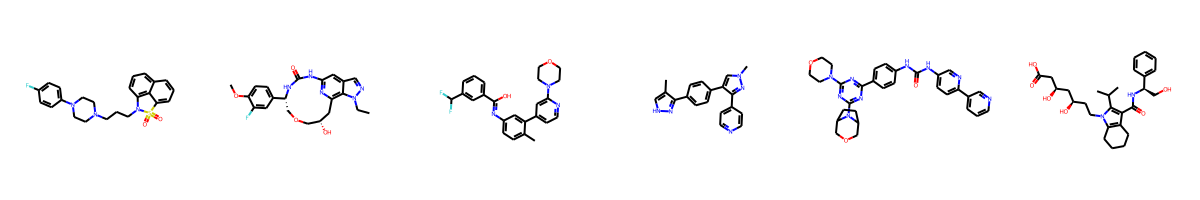

In [10]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in idg_sample.cansmi], molsPerRow=6)

<img align="right" height="60" src="https://maayanlab.cloud/sigcom-lincs/static/NIHLINCS.jpg">

### LINCS sample
Sample compounds from the LINCS table.

In [11]:
lincs_sample = pd.read_sql("SELECT * FROM lincs WHERE cansmi IS NOT NULL ORDER BY RANDOM() LIMIT 6", dbcon)
lincs_sample


,id,pert_name,target,moa,smiles,inchi_key,compound_aliases,sig_count,cansmi,mol_id
0,BRD-K96309168,BRD-K96309168,None,None,C[C@@H](CO)N1C[C@H](C)[C@@H](CN(C)Cc2ccccc2)OC...,OANCONKVZGQSHB-CLFOAKAGSA-N,None,2,C[C@H]1CCCCO[C@H](CN(C)Cc2ccccc2)[C@@H](C)CN([...,256588
1,BRD-K46629170,BRD-K46629170,None,None,COc1ccc(CN(C)C[C@@H]2OCCCC[C@@H](C)Oc3ccc(NC(=...,UVSCGJDGVAXROK-GBJJYOARSA-N,None,2,COc1ccc(CN(C)C[C@@H]2OCCCC[C@@H](C)Oc3ccc(NC(=...,260943
2,BRD-K97821886,BRD-K97821886,None,None,CO[C@H]1CN(C)C(=O)c2ccc(NC(=O)C3CC3)cc2OC[C@H]...,RHXUULWZVSTJED-MHPIHPPYSA-N,None,3,CO[C@H]1CN(C)C(=O)c2ccc(NC(=O)C3CC3)cc2OC[C@H]...,269657
3,BRD-A21584801,brivanib,"KDR, FLT1, FGFR1","FGFR inhibitor, VEGFR inhibitor",CC(O)COc1cn2ncnc(Oc3ccc4[nH]c(C)cc4c3F)c2c1C,WCWUXEGQKLTGDX-UHFFFAOYSA-N,None,156,Cc1cc2c(F)c(Oc3ncnn4cc(OCC(C)O)c(C)c34)ccc2[nH]1,251820
4,BRD-K31302860,BRD-K31302860,None,None,CC(C)NC(=O)Nc1ccc2O[C@@H](C)CCCCO[C@H](CN(C)Cc...,YBLKRDGTGIUFGT-ZASNTINBSA-N,None,15,CC(C)NC(=O)Nc1ccc2c(c1)C(=O)N([C@H](C)CO)C[C@@...,260893
5,BRD-K90733601,BRD-K90733601,None,None,COc1ccccc1NC(=O)N1C[C@H]2N[C@@H](C1)[C@@H]2c1c...,IVAIQDPURPPSLV-XNSYCPOSSA-N,None,3,COc1ccccc1NC(=O)N1C[C@H]2N[C@@H](C1)[C@@H]2c1c...,271461


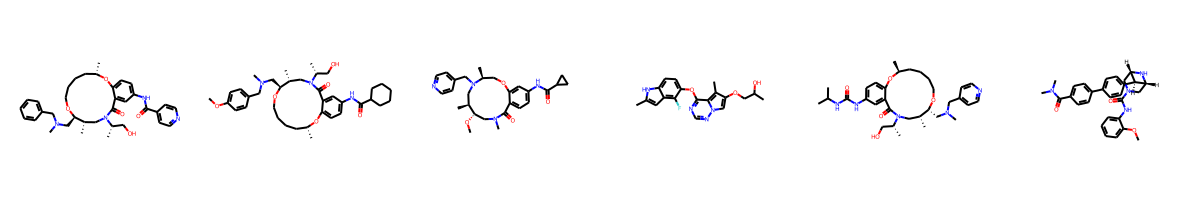

In [12]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in lincs_sample.cansmi], molsPerRow=6)

## Define query: Dopamine

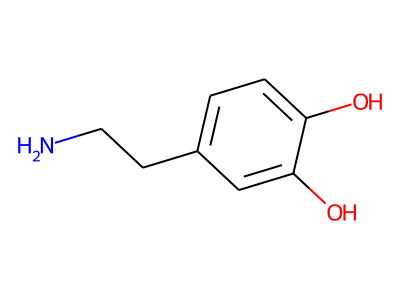

In [13]:
query_smiles = "NCCc1ccc(O)c(O)c1"
Draw.MolToImage(Chem.MolFromSmiles(query_smiles), size=(400, 300)) 

### Simple substructure search
See https://rdkit.readthedocs.io/en/latest/Cartridge.html#reference-guide for chemical search syntax and other details.

In [14]:
sub_results = pd.read_sql(f"SELECT id, name, cansmi AS smiles FROM mols WHERE molecule @> '{query_smiles}' AND name IS NOT NULL ORDER BY LENGTH(cansmi) LIMIT 10", dbcon)
sub_results

,id,name,smiles
0,306,Dophamine,NCCc1ccc(O)c(O)c1
1,1082,Topamine,NCCc1cc(O)c(O)cc1O
2,316,Noradrop,NCC(O)c1ccc(O)c(O)c1
3,5231,CID517540,Cl.NCCc1ccc(O)c(O)c1
4,119293,BDBM50416831,COc1ccc(CCN(C)N)cc1OC
5,438,SCHEMBL1691820,NCC(O)c1cc(O)c(O)cc1F
6,218,CID4866774,CNCC(O)c1ccc(O)c(O)c1
7,710,ADTN,NC1CCc2cc(O)c(O)cc2C1
8,403,Tenamfetamine,CC(N)Cc1ccc2c(c1)OCO2
9,404,Ecstasy,CNC(C)Cc1ccc2c(c1)OCO2


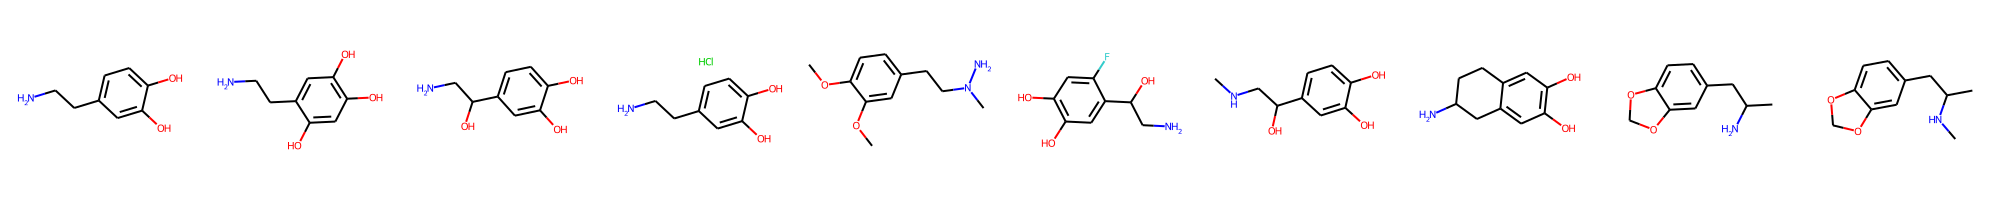

In [15]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in sub_results["smiles"]], molsPerRow=10)

Use operator "@<" for _substructures of query_. 

In [23]:
sub_results = pd.read_sql(f"SELECT id, name, cansmi AS smiles FROM mols WHERE molecule <@ '{query_smiles}' ORDER BY LENGTH(cansmi) DESC LIMIT 10", dbcon)
sub_results

,id,name,smiles
0,306,Dophamine,NCCc1ccc(O)c(O)c1
1,307,None,NCCc1ccc(O)c(O)c1
2,285010,None,Cc1ccc(O)c(O)c1
3,276689,None,NCCc1cccc(O)c1
4,1324,Uteramine,NCCc1ccc(O)cc1
5,285079,None,CCc1ccc(O)cc1
6,666,Tricresol,Cc1ccc(O)cc1
7,294,Tricresol,Cc1cccc(O)c1
8,287695,None,NCCc1ccccc1
9,285016,None,Oc1ccccc1O


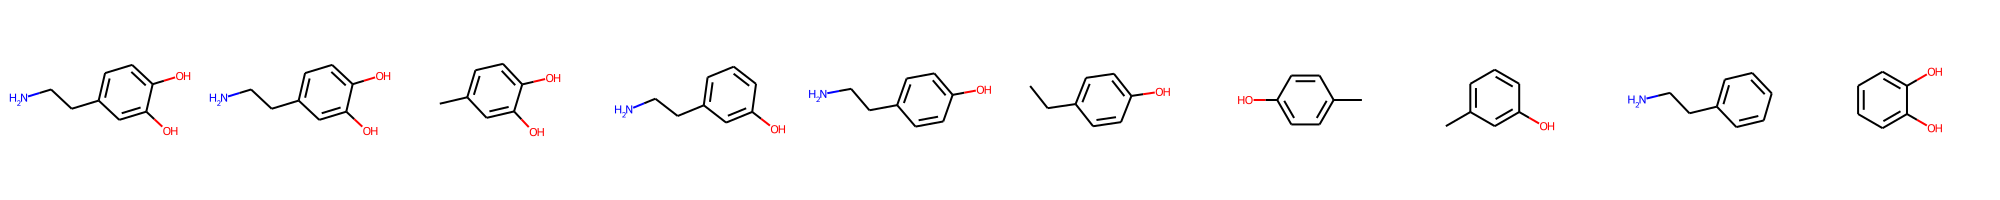

In [24]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in sub_results["smiles"]], molsPerRow=10)

### Similarity search joining LINCS and DrugCentral
Joining on the mol_id field is equivalent by design to joining on canonical smiles, which are unique identifiers for the standardized molecular graph of the drug molecule. Molecules from each source are standardized and assigned mol_id's by the ETL processing workflows.

In [18]:

results = pd.read_sql(f"""SELECT
	mols.id, mols.cansmi AS smiles,
	drugcentral.id AS dc_id, drugcentral.name AS drugname,
	lincs.pert_name AS lincs_name, lincs.sig_count,
	tanimoto_sml(rdkit_fp(mol_from_smiles('{query_smiles}'::cstring)), mols.fp) similarity
FROM mols
JOIN drugcentral ON (drugcentral.mol_id = mols.id)
JOIN lincs ON (lincs.mol_id = mols.id)
WHERE rdkit_fp(mol_from_smiles('{query_smiles}'::cstring)) % mols.fp
ORDER BY similarity DESC""", dbcon)
results

,id,smiles,dc_id,drugname,lincs_name,sig_count,similarity
0,1388,CNC[C@H](O)c1ccc(O)c(O)c1,1028,epinephrine,epinephrine,132,0.687831
1,254213,CC(N)Cc1ccc(O)cc1,1394,hydroxyamfetamine,hydroxyamphetamine,3,0.662252
2,12420,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,1567,levodopa,levodopa,6,0.650000
3,740,C=CCc1ccc(O)c(OC)c1,4648,eugenol,eugenol,265,0.636872
4,264,CC(C)NC[C@H](O)c1ccc(O)c(O)c1,2388,levisoprenaline,isoprenaline,4,0.628019
5,255606,CCNCC(O)c1cccc(O)c1,1101,etilefrine,etilefrine,16,0.569231
6,252167,CNCC(O)c1ccc(O)cc1,3577,oxedrine,synephrine,26,0.560440
7,1939,C[C@](N)(Cc1ccc(O)c(O)c1)C(=O)O,1762,methyldopa,methyldopa,217,0.560345
8,259675,C[C@H](N)[C@H](O)c1cccc(O)c1,1721,metaraminol,metaraminol,5,0.528571
9,952,CC(C)NCC(O)c1cc(O)cc(O)c1,1720,orciprenaline,orciprenaline,168,0.528302


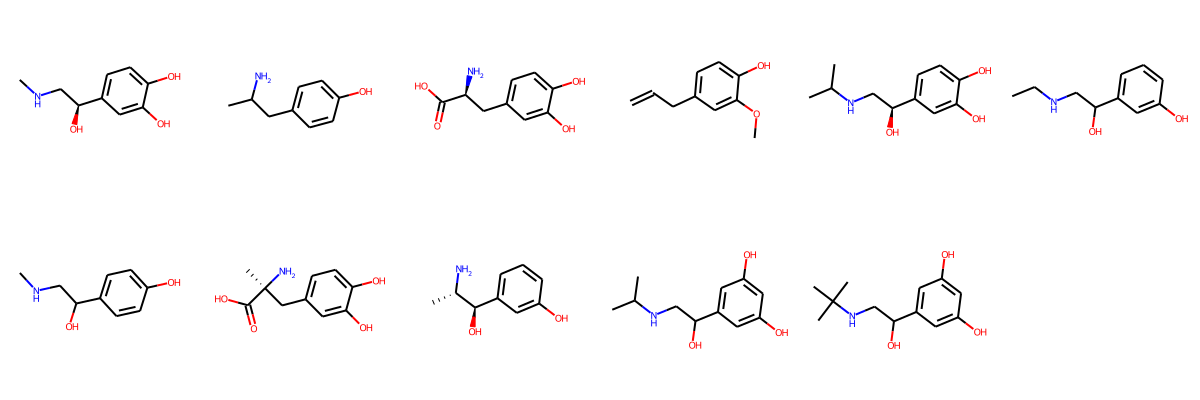

In [19]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in results["smiles"]], molsPerRow=6)

,img,id,dc_id,drugname,similarity
0,,1388,1028,epinephrine,0.69
1,,254213,1394,hydroxyamfetamine,0.66
2,,12420,1567,levodopa,0.65
3,,740,4648,eugenol,0.64
4,,264,2388,levisoprenaline,0.63
5,,255606,1101,etilefrine,0.57
6,,252167,3577,oxedrine,0.56
7,,1939,1762,methyldopa,0.56
8,,259675,1721,metaraminol,0.53
9,,952,1720,orciprenaline,0.53

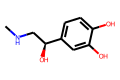
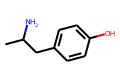
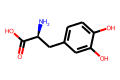
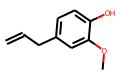
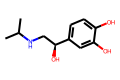
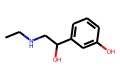
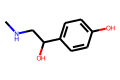
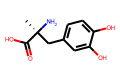
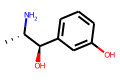
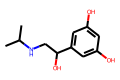
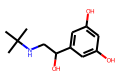

In [20]:
for i,smi in enumerate(results["smiles"]):
  mol = Chem.MolFromSmiles(smi)
  img = Draw.MolToImage(mol, size=(120, 80))
  img_buffer = io.BytesIO()
  img.save(img_buffer, format="PNG")
  imgStr = base64.b64encode(img_buffer.getvalue()).decode('utf8')
  results.loc[i,'img'] = f"""<img src="data:image/png;base64,{imgStr}">"""
display(HTML(results[["img", "id", "dc_id", "drugname", "similarity"]].round(2).to_html(escape=False)))